  0%|          | 0/100 [00:00<?, ?it/s]

player_target_state_values_diff has converged



  0%|          | 0/100 [00:00<?, ?it/s]

player_target_state_values_diff has converged



  0%|          | 0/100 [00:00<?, ?it/s]

player_target_state_values_diff has converged



  0%|          | 0/100 [00:00<?, ?it/s]

player_target_state_values_diff has converged



  0%|          | 0/100 [00:00<?, ?it/s]

player_target_state_values_diff has converged



100%|██████████| 6/6 [00:57<00:00,  9.58s/it]


player_target_state_values_diff has converged


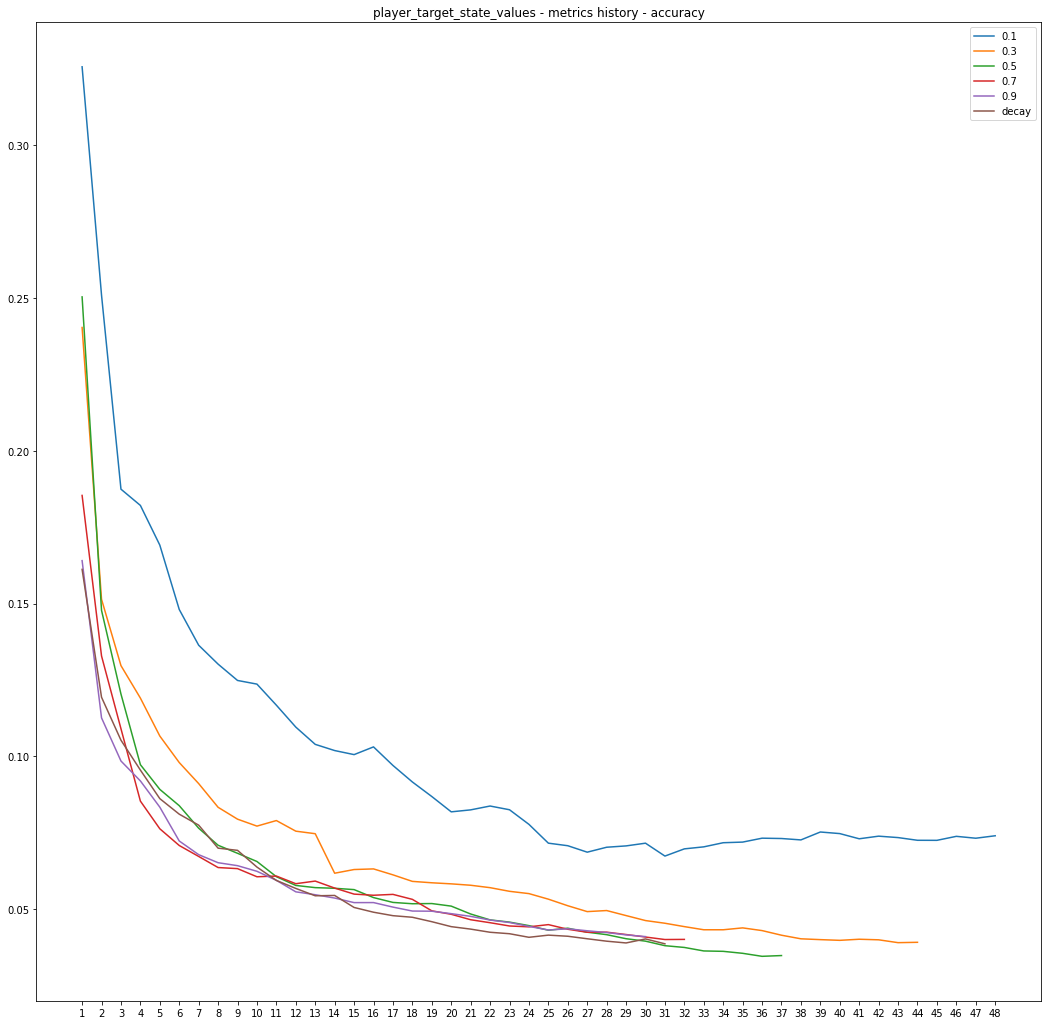

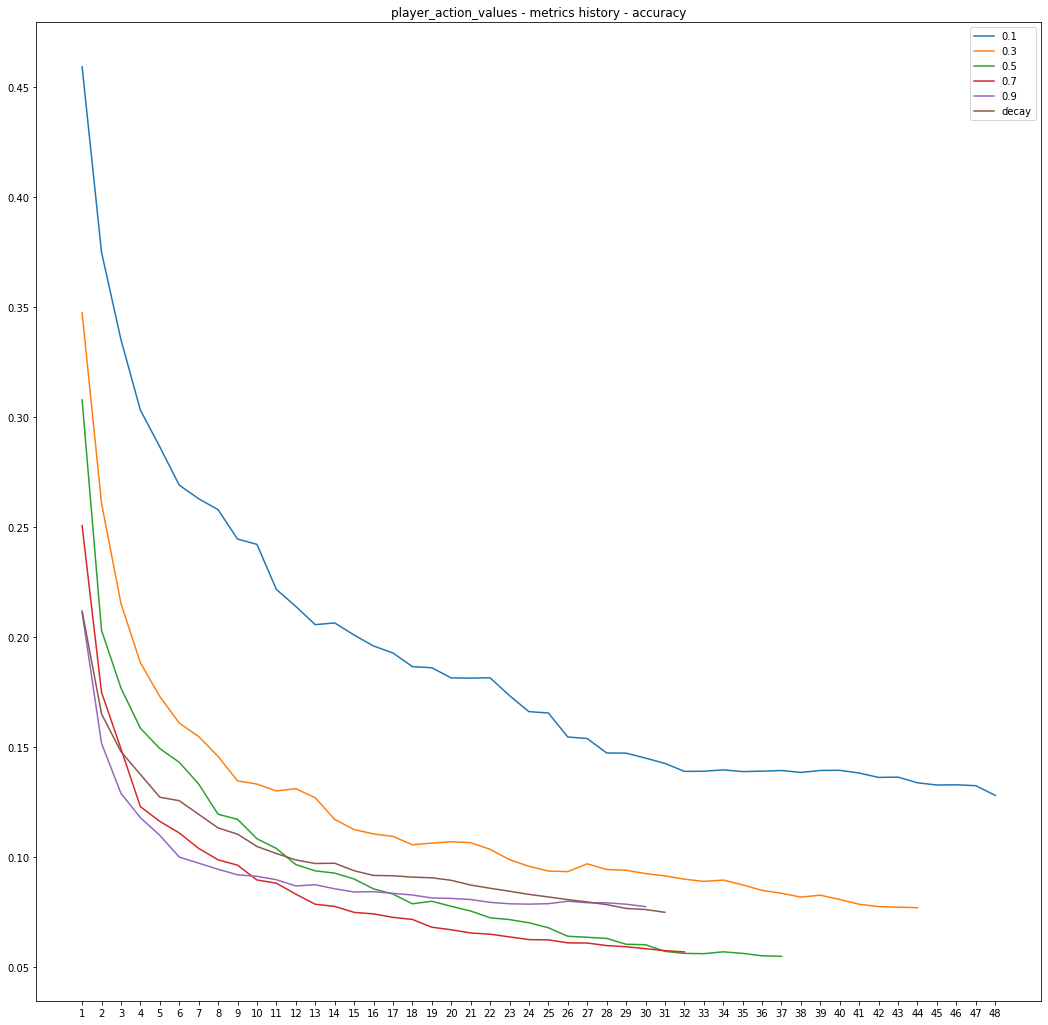

In [2]:
# TASK:
# - check exploration_rate ~ (convergence, accuracy)
#
# PROCESS:
# - monte_carlo_control (e_greedy_policy & monte_carlo_learning_offline)
# - different exploration_rate until action_value_store/target_state_value_store
#   converges
# - record convergence and accuracy of target_state_value_store,
#   action_value_store
# - check exploration_rate ~ convergence, convergence_accuracy
# - check accuracy history of both stores
#
# RESULT:
# when action_value_store converges,
# - exploration_rate = 0.1, worst convergence and accuracy on both
#   target_state_value_store and action_value_store
# - exploration_rate = 0.3, convergence is better than 0.1 worse than higher,
#   accuracy is worse than 0.5
# - exploration_rate = 0.5, best accuracy on both balanced with good convergence
# - exploration_rate = 0.7, convergence is better than 0.5, but accuracy is
#   worse than 0.5
# - exploration_rate = 0.9, convergence is quick but accuracy is worse than 0.7
# when target_state_value_store converges,
# - exploration_rate = 0.1 has the worse everything again
# - exploration_rate = 0.5 has the best accuracy of both stores
#   and medium convergence
# - difference is mainly that exploration_rate=0.1 has quicker convergence
#   than 0.3, but much worse accuracy
# - decaying exploration_rate has a accuracy and convergence similar to 0.9
#
#
# INTERPRETATION:
# - action_value_store convergence is faster generally with a higher
#   exploration_rate
# - there's a sweet spot to have best balance of accuracy and convergence,
#   for both convergence conditions, 0.5 has been promising
# - indication: accuracy ~ (exploration_rate-balanced)^2
# - when exploration_rate is too high, optimal policy trajectories are
#   undersampled, resulting in worse accuracy in optimal action values
# - for convergence on target_state_value_store, when exploration_rate is too low
#   it is possible to converges with less accuracy, as sampling stucked in
#   suboptimal action trajectories
#
# RUN:
# %%
import sys

sys.path.append("../")

from numpy import arange
from tqdm import tqdm, trange

from src.module.model_free_agent import ModelFreeAgent

from src.easy_21.game import playout, ACTIONS

#
# hyperparameters and agent config
#
BATCH = 100
EPISODES = int(1e4)

DIFF_THRESHOLD = 0.005

PLAYER = ModelFreeAgent("player", ACTIONS)

PLAYER.load_optimal_state_values()
PLAYER.true_action_value_store.load("../output/player_true_action_values.json")

PLAYER.target_state_value_store.metrics_methods[
    "accuracy"
] = PLAYER.target_state_value_store_accuracy_to_optimal
PLAYER.action_value_store.metrics_methods[
    "accuracy"
] = PLAYER.action_value_store_accuracy_to_true

#
# task process
#
exploration_rate_range = [*arange(0.1, 1.1, 0.2), "decay"]


for exploration_rate in tqdm(exploration_rate_range):

    PLAYER.action_value_store.reset()
    PLAYER.target_state_value_store.reset()

    for n in trange(BATCH):
        for _ in range(EPISODES):
            playout(
                player_policy=lambda state_key: PLAYER.e_greedy_policy(
                    state_key,
                    exploration_rate=(1 - n / BATCH)
                    if exploration_rate == "decay"
                    else exploration_rate,
                ),
                player_offline_learning=PLAYER.monte_carlo_learning_offline,
            )

        PLAYER.action_value_store.record("accuracy", log=False)
        PLAYER.target_state_value_store.record("accuracy", log=False)

        if PLAYER.target_state_value_store.record_and_check_convergence(
            "diff", DIFF_THRESHOLD, log_record=False
        ):
            PLAYER.action_value_store.stack_metrics_history("accuracy")
            PLAYER.target_state_value_store.stack_metrics_history("accuracy")
            PLAYER.target_state_value_store.reset_metrics_history("diff")
            break

labels = [f"{r:.1f}" if r != "decay" else r for r in exploration_rate_range]
PLAYER.target_state_value_store.plot_metrics_history_stack(
    "accuracy",
    labels=labels,
)
PLAYER.action_value_store.plot_metrics_history_stack(
    "accuracy",
    labels=labels,
)
